In [1]:
# IMPORTS

from GridClass import *

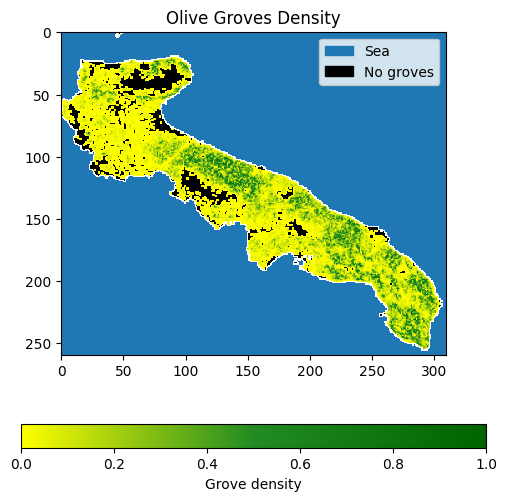

In [2]:
np.random.seed(100)

# GRID INSTANCE INITIALIZATION PARAMETERS
FROM_FILE = True
ROWS = 10 # Random grid
COLS = 10 # Random grid

# CREATE OLIVE GROVE DENSITY, FROM FILE OR RANDOMLY GENERATED
if FROM_FILE:
    file_path = "olivegrowthprop.mat"
    mat = sp.io.loadmat(file_path)
    GRID = Grid(density=mat["olivegrowthprop"])

else:
    GRID = Grid(shape=(ROWS, COLS))

# PLOT DISTRIBUTION OF OLIVE GROVES
GRID.plot_density(figsize=(6,6))

In [5]:
# SIMULATION PARAMETERS
# Control zone parameters
control = True
EZW = 20
BZW = 30
EZ_eff = 1
BZ_eff = 0.5

# Common parameters
A = 3 # 3 kp rate of population growth
B = 14.069
a = 0 # relative carrying capacity in non olive plants
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Dispersal type
dispersal_type = "short_long" # short_long, levy_flight

# Short distance kernel
beta = 0.1
kernel_type = "exponential"

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 20 # 20 dispersal standard deviation

# Power law kernel (Levy flight)
d_min = 0.1
d_max = 20 # None
alpha = 7

# Define parameter dictionary (to be fed to .simulate())
parameters = {'control_zone': [control, EZW, BZW, EZ_eff, BZ_eff],
              'common': [A, B, a, tol],
              'dispersal': [dispersal_type],
              'short_long': [beta, kernel_type, disp_tol, M_max, D],
              'levy_flight': [d_min, d_max, alpha]}

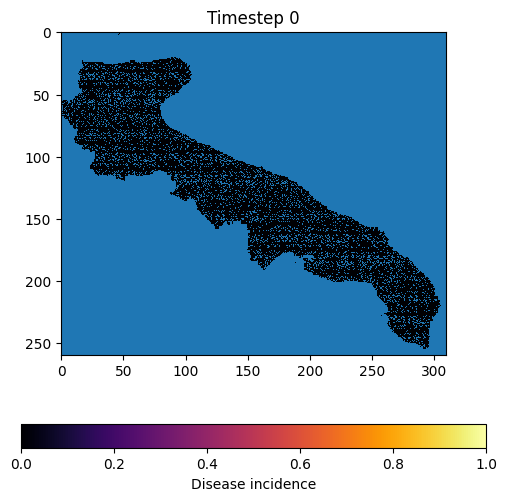

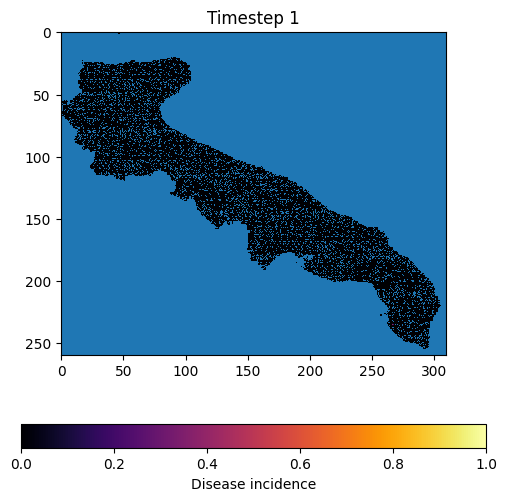

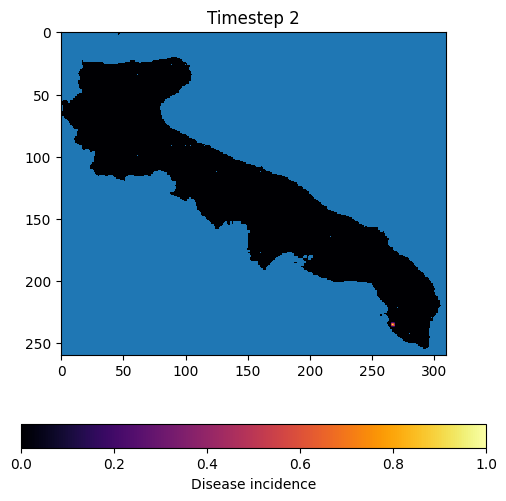

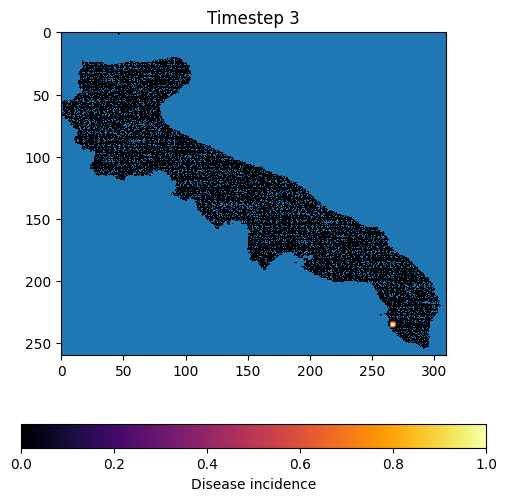

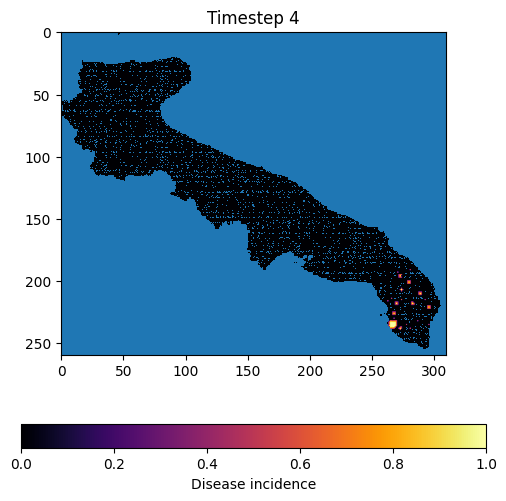

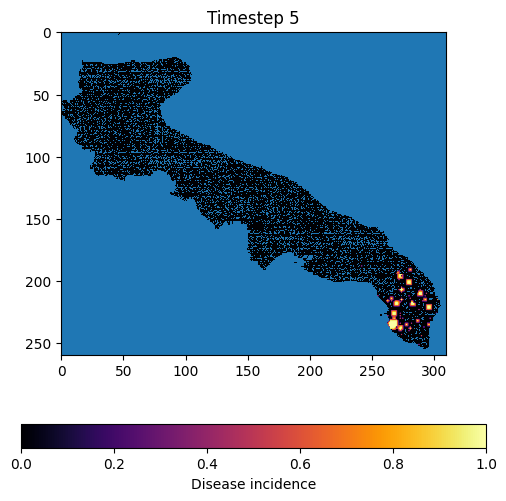

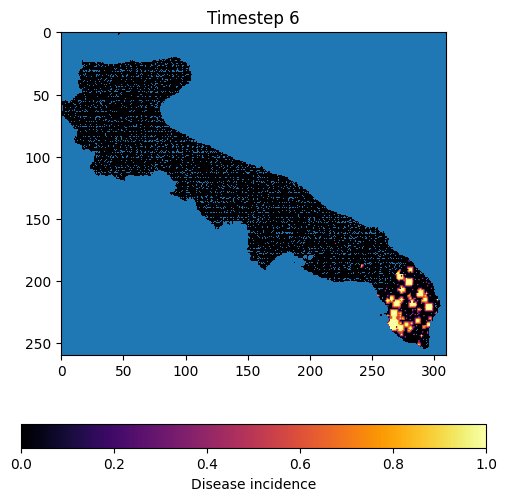

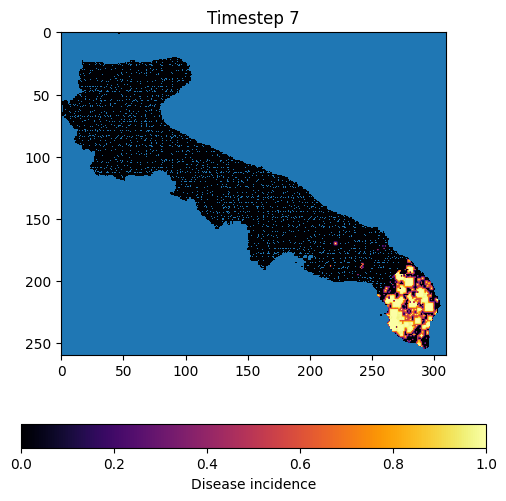

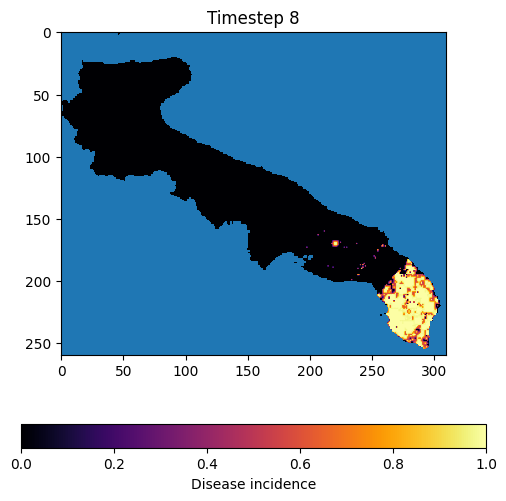

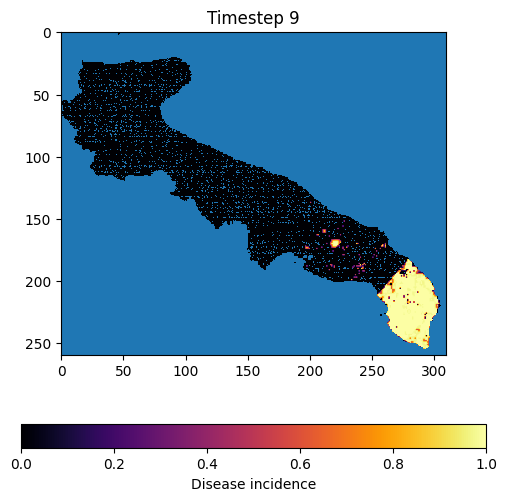

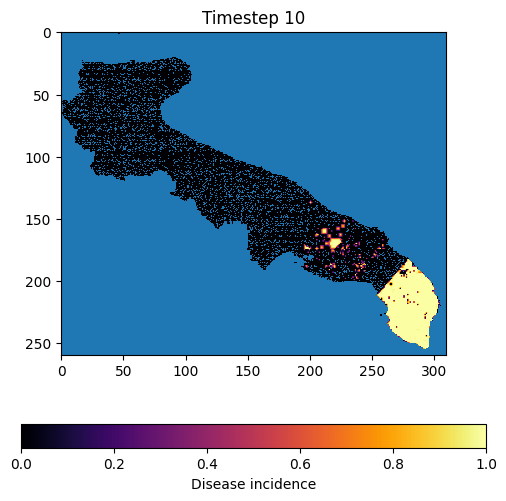

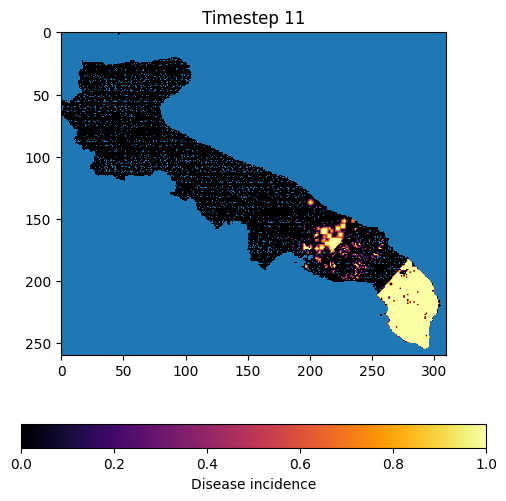

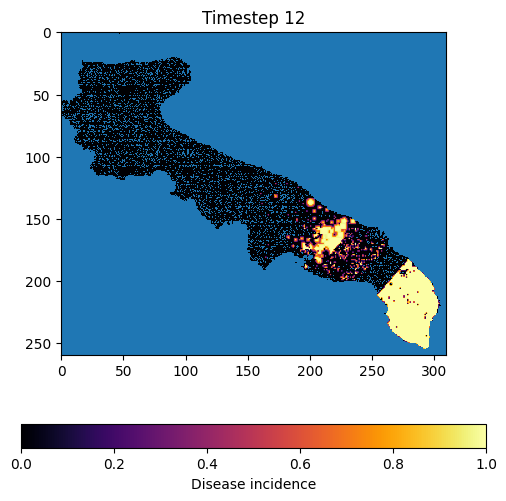

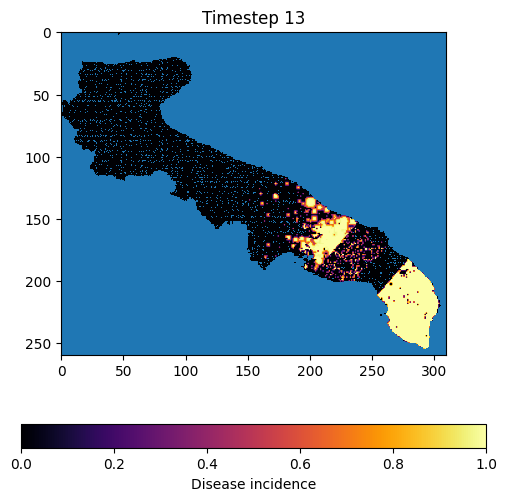

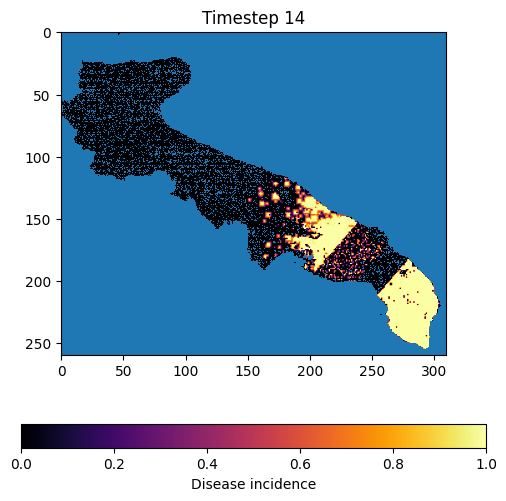

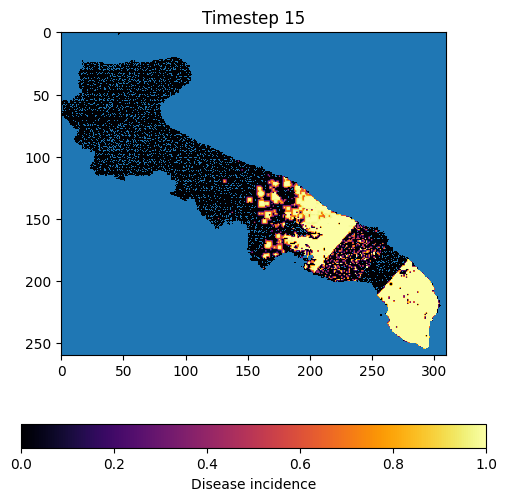

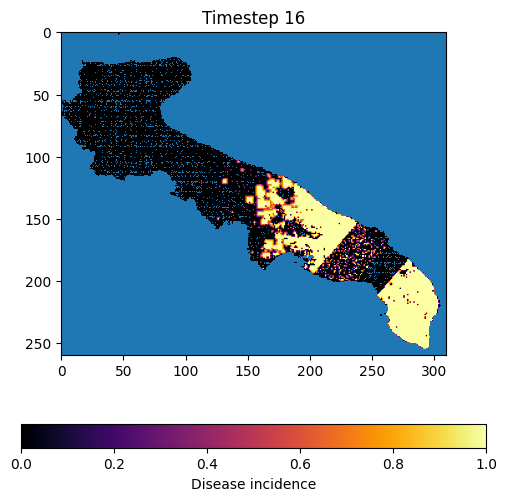

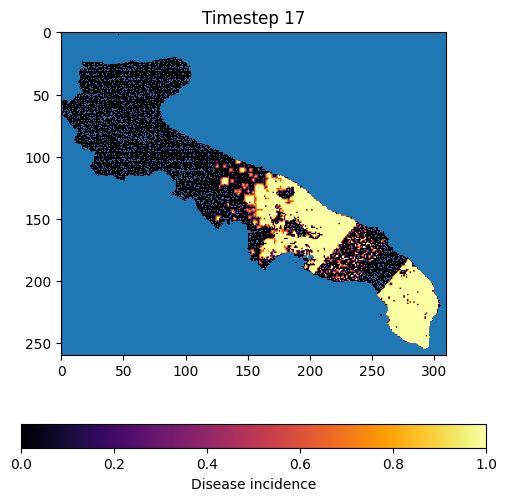

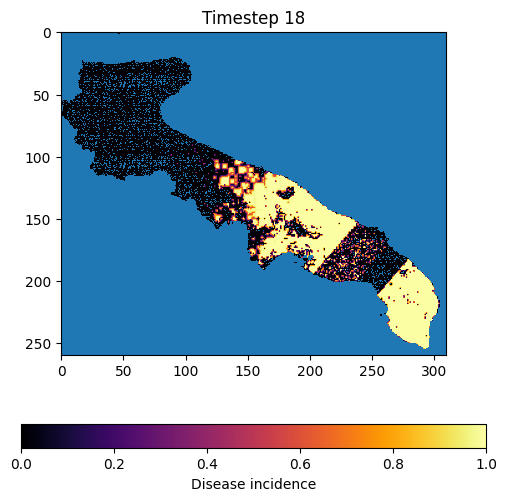

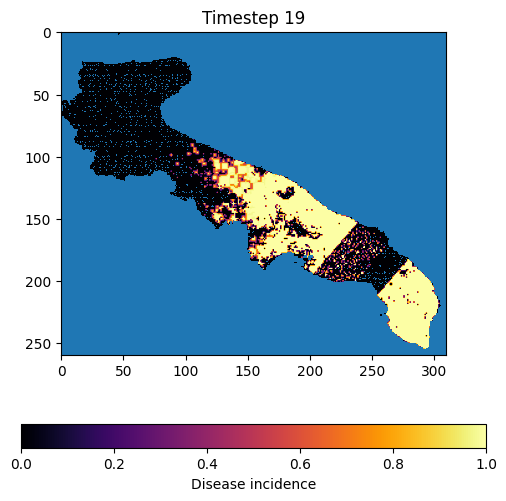

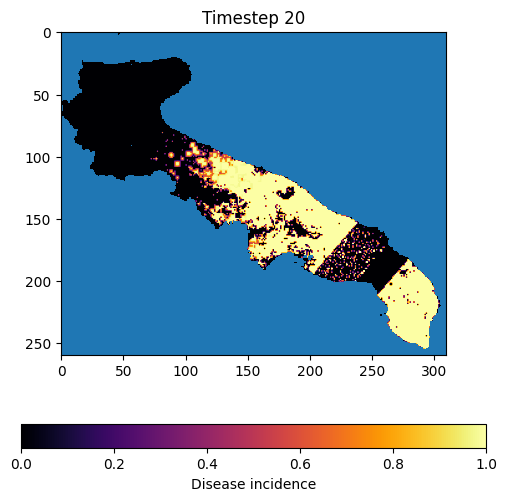

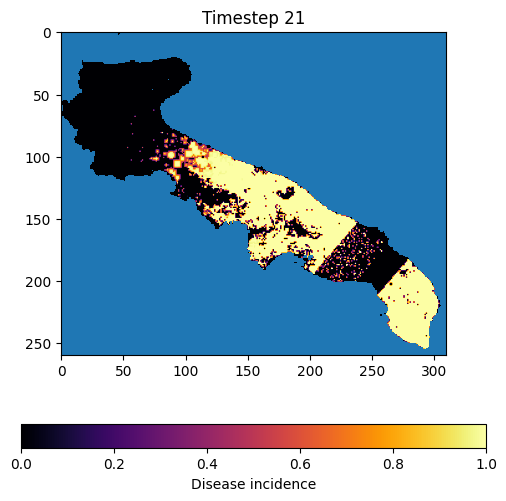

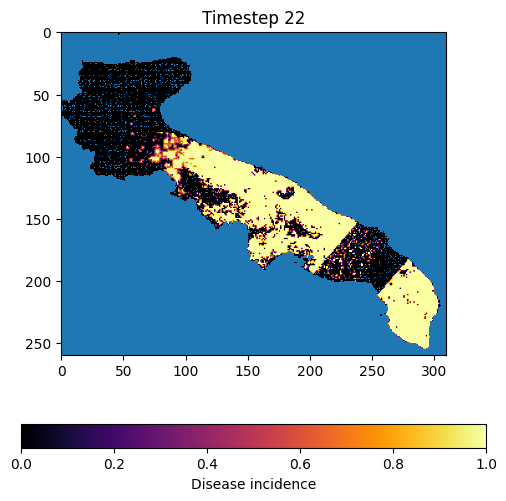

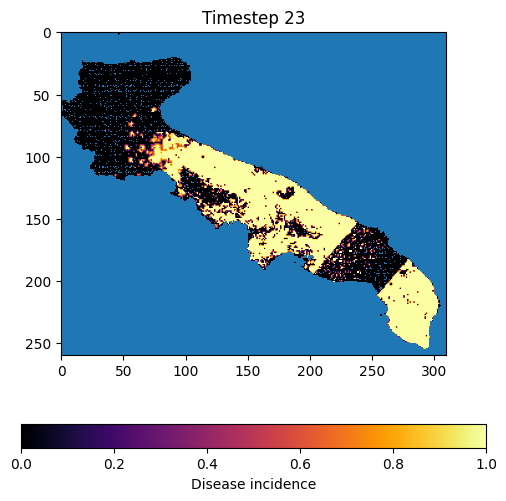

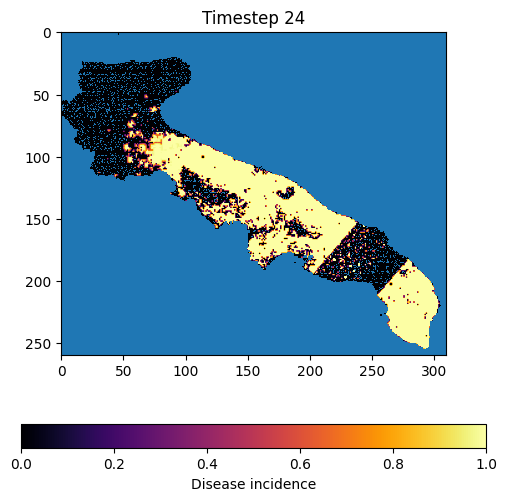

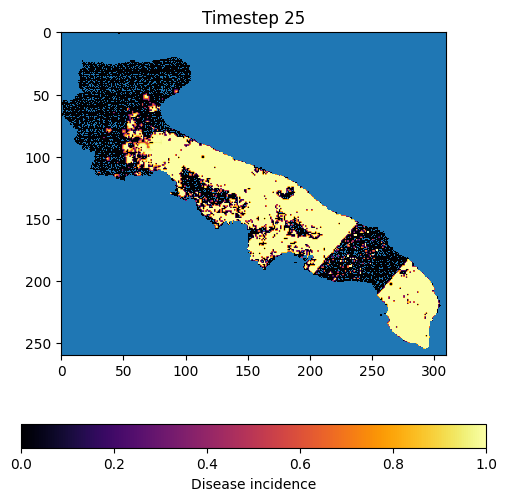

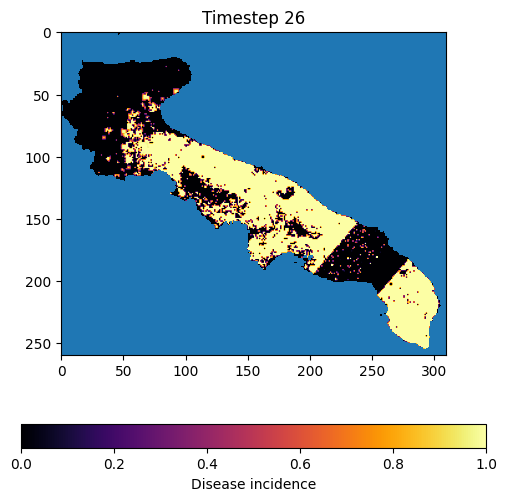

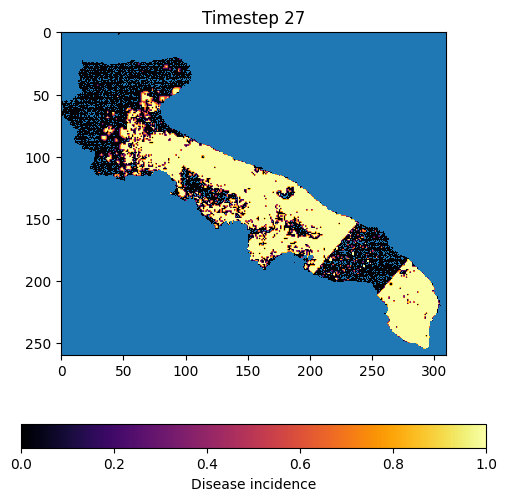

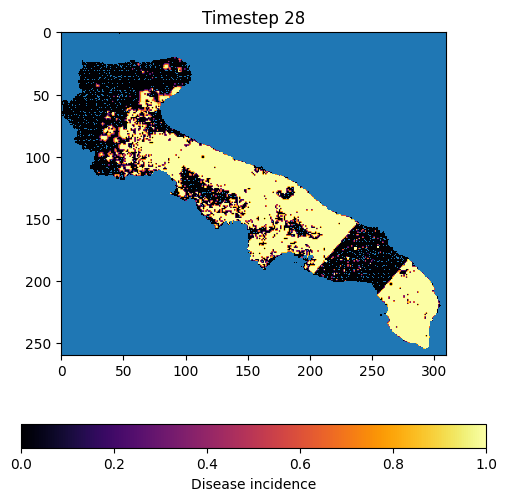

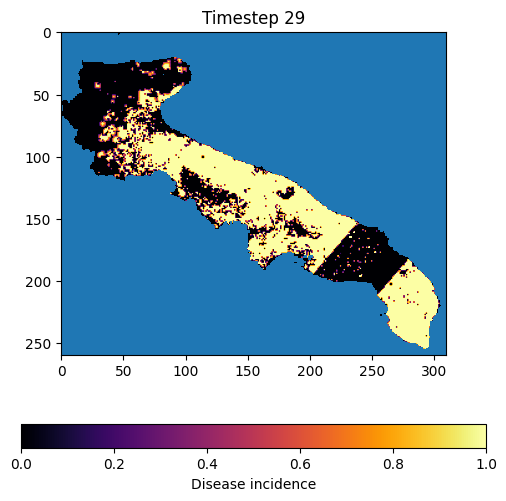

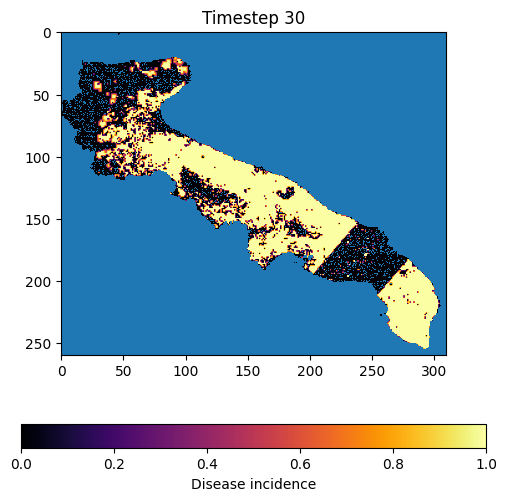

In [7]:
# RUN SIMULATION AND PLOT OUTCOME

# np.random.seed(5)

timesteps = 30

GRID.simulate(timesteps, parameters)
GRID.plot_incidence(figsize=(6,6))
# GRID.plot_final_incidence(figsize=(6,6))

[[235 266]]
[[234 265]
 [234 266]
 [234 267]
 [235 265]
 [235 266]
 [235 267]
 [236 265]
 [236 266]
 [236 267]]
[ 0.          1.07298381  3.99022143 11.07416254 16.60575672 22.12249343
 26.35489265 29.96220634 34.80223759 40.82238991 47.1751261 ]


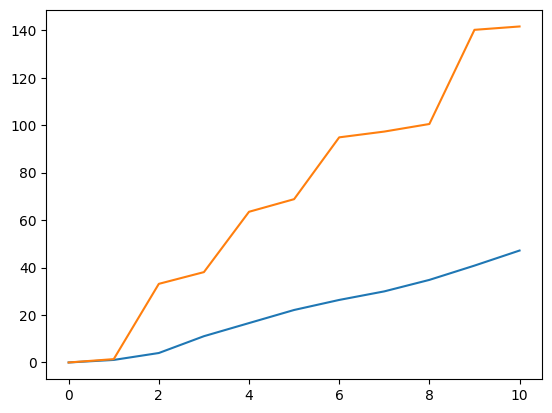

In [24]:
avg_distance = np.zeros(GRID.timesteps+1)
max_distance = avg_distance.copy()

for t in range(timesteps+1):
    infected_mask = GRID.I[t] > 0
    infected_coordinates = np.argwhere(infected_mask)
    if t == 0 or t == 1:
        print(infected_coordinates)
    distances = np.linalg.norm(infected_coordinates - GRID.seed, axis=1)
    avg_distance[t] = np.mean(distances)
    max_distance[t] = np.max(distances)

print(avg_distance)

plt.plot(np.arange(timesteps+1), avg_distance)
plt.plot(np.arange(timesteps+1), max_distance)
plt.show()

In [40]:
# # EVALUATE RISK

# N = 5
# timesteps = 10
# GRID.evaluate_risk(N, timesteps, parameters)

In [41]:
# # PLOT RISK AT DIFFERENT TIMES

# im_sea = np.ma.array(GRID.density, mask=~GRID.sea_mask)

# ncols = 5
# images = []
# fig, ax = plt.subplots(1, ncols, figsize=(ncols*4,4))
# for i in range(ncols):
#     images.append(ax[i].imshow(GRID.risk[1+2*i], cmap="inferno", interpolation=None, norm=colors.Normalize(vmin=0, vmax=1)))
#     ax[i].imshow(im_sea, cmap=colors.ListedColormap(['tab:blue']), interpolation=None)
#     ax[i].set_title(f"{1+2*i}-year risk")
# cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal")
# cbar.set_label("Risk")

# plt.show()

In [42]:
# # EVALUATE RISK (AVERAGE INCIDENCE) OVER GRID TIMESERIES
# # Short_long kernel with and without Control Zone

# average = np.zeros(GRID.timesteps+1)

# for t in range(GRID.timesteps+1):
#     average[t] = GRID.risk[t][GRID.grove_mask].mean()
    
# plt.plot(np.arange(GRID.timesteps+1), average)
# plt.show()

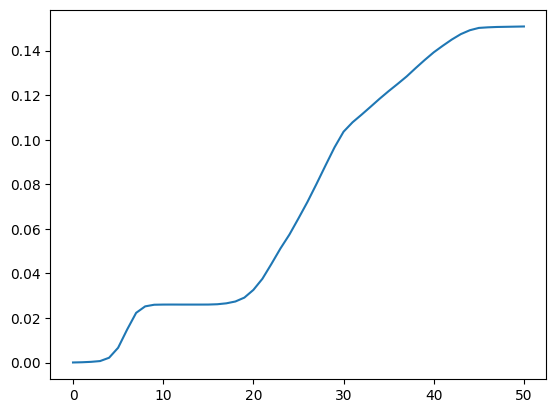

In [43]:
# PERCENTAGE OF GROVES THAT ARE INFECTED (ASSUMING 1 GROVE=1 GRID CELL)
# The Gompertz growth model grows very quickly even extremely small numbers.
# One year (one iteration) is typically enough to have a sizable value for I (incidence)
# So I will coansider as infected, all those groves above the tolerance value 'tol'

percentage_of_groves = np.zeros(GRID.incidence.shape[0])

for t in range(GRID.timesteps+1):
    percentage_of_groves[t] = len(GRID.incidence[t][GRID.incidence[t] > tol]) / len(GRID.grove_mask.flatten())

plt.plot(np.arange(GRID.timesteps+1), percentage_of_groves)

plt.show()

In [44]:
N = 2
timesteps = 5

# GRID.simulate(timesteps, parameters)
GRID.evaluate_risk(N, timesteps, parameters)

# print(GRID.incidence.shape)
print(GRID.risk.shape)

(6, 260, 310)


In [52]:
# RUN SIMULATION FOR DIFFERENT PARAMETERS

N = 10
timesteps = 10
EZW_list = [10, 20, 30]
percentage_of_groves = np.zeros((len(EZW_list), GRID.timesteps+1))
# print(percentage_of_groves.shape)

for i, EZW in enumerate(EZW_list):
    parameters = {'control_zone': [control, EZW, BZW, BZ_eff],
                  'common': [A, B, a, tol],
                  'dispersal': [dispersal_type],
                  'short_long': [beta, kernel_type, disp_tol, M_max, D],
                  'levy_flight': [n_vectors, d_min, d_max, alpha, sample]}

    # GRID.simulate(timesteps, parameters)
    GRID.evaluate_risk(N, timesteps, parameters)
    # GRID.plot_density(figsize=(6,6))
    # GRID.plot_final_incidence(figsize=(6,6))

    for t in range(GRID.timesteps+1):
        # percentage_of_groves[i,t] = len(GRID.incidence[t][GRID.incidence[t] > tol]) / len(GRID.grove_mask.flatten())
        percentage_of_groves[i,t] = len(GRID.risk[t][GRID.risk[t] > tol]) / len(GRID.grove_mask.flatten())


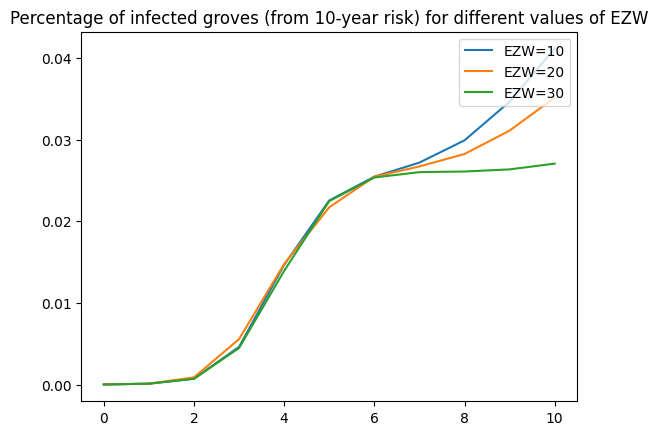

In [55]:
# PLOT PERCENTAGE OF INFECTED GROVES FOR DIFFERENT PARAMETER VALUES

for i, EZW in enumerate(EZW_list):
    plt.plot(np.arange(GRID.timesteps+1), percentage_of_groves[i], label=f'EZW={EZW}')

plt.legend(loc='upper right')
plt.title(f"Percentage of infected groves (from {timesteps}-year risk) for different values of EZW")
plt.show()

In [ ]:
# First interesting result: the size of the control zone determines a delay in the epidemic spread
# Explore different values for EZW and BZW
# Calculate time delay from simulation
# The increase in average incidence and percentage of infected groves increases linearly with time
# This reflects a constant speed for the infection front

# Differences in this regard between short_long and levy_flight. Levy_flight needs more time to 
# resume same pace (?): verify.  

In [ ]:
# INCLUDE VECTOR POPULATION DYNAMICS

In [ ]:
# EVALUATE SPEED OF EPIDEMIC SPREAD 

# Get the centroid of each grid cell. 
# Create distance classes:
# - 1 km radius around centroid of seed cell (includes all cells whose centroid is within the radius)
# - 1 km wide concentric rings around centroid of seed cell (same) 

In [ ]:
# add "scale" parameter for rescaling of random samples; resolved by simply modifying alpha exponent parameter
